In [1]:
import numpy as np
import pandas as pd
import plotnine as p9
import cowpatch as cow
from plotnine.data import mtcars
import copy
import re


In [2]:
a = (p9.ggplot(mtcars) 
    + p9.aes('wt', 'mpg', color='hp') 
    + p9.geom_point() 
    + p9.theme(figure_size=(3, 2))
    )

b = (p9.ggplot(mtcars) 
    + p9.aes('wt', 'mpg', color='hp') 
    + p9.geom_point() 
    + p9.scale_color_continuous('inferno')
    + p9.theme(figure_size=(3, 2))
    )

# this plot has no point, just helps with a different structural example.
c = (p9.ggplot(mtcars)
    + p9.aes("wt", "mpg") 
    + p9.geom_point() 
    + p9.facet_wrap("cyl")
    )


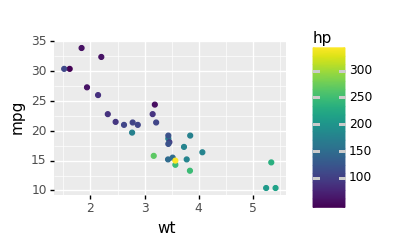

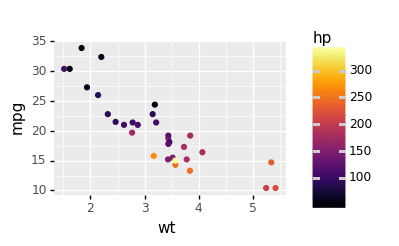

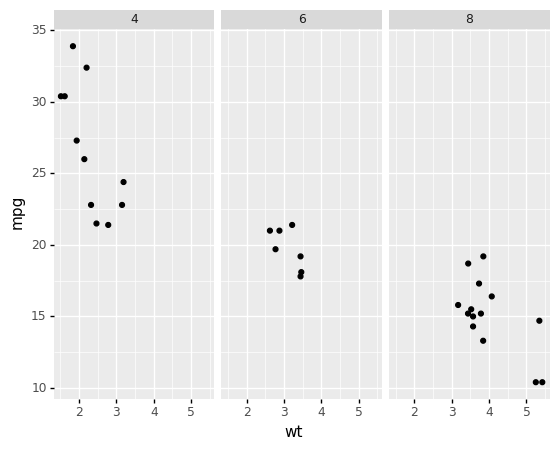

In [3]:
print(a);print(b); print(c)

In [4]:
# global parameters injected into the patch object's _svg function
store_images = {}
store_location = {}

In [5]:
# code from base_elements.py

import numpy as np
import plotnine as p9
import matplotlib.pyplot as plt
import svgutils.transform as sg

from cowpatch.svg_utils import gg_to_svg, _save_svg_wrapper, _show_image, \
                    _raw_gg_to_svg, _select_correcting_size_svg
from cowpatch.utils import to_inches, from_inches, inherits_plotnine, inherits, \
                    _flatten_nested_list
from cowpatch.layout_elements import layout
from cowpatch.config import rcParams

import pdb


class patch:
    def __init__(self, *args, grobs=None):
        """
        fundamental object of `cowpatch`, encapsulates plot objects and
        can be told how to present them

        Arguments
        ---------
        \*args : plot objects and patches
            all non-named parameters are expected to be plot objects or
            lower-level ``cow.patch`` objects.
        grobs : list
            list of plot objects and patches. Either ``\*args`` is empty or
            ``grobs`` is ``None``.


        Notes
        -----

        *Guiding arangement:*

        In combination with ``cow.layout`` one can define arrangement of plots
        and lower-level arangements.

        For example,

        >>> vis_obj = cow.patch(g1,g2,g3)
        >>> vis_obj += cow.layout(design = np.array([[0,1],
        ...                                          [2,2]]))
        >>> vis_obj.show()

        See the `Layout guide`_ for more detailed examples of functionality.

        .. _Layout guide: https://benjaminleroy.github.io/cowpatch/guides/Layout.html

        *Nesting:*

        One can nest `cow.patch` objects within other `cow.patch` objects. For
        example,

        >>> vis_obj2 = cow.patch(g4, vis_obj)
        >>> vis_obj2 += cow.layout(nrow = 1)
        >>> vis_obj2.show()

        Examples
        --------

        >>> # Necessary libraries for example
        >>> import numpy as np
        >>> import cowpatch as cow
        >>> import plotnine as p9
        >>> import plotnine.data as p9_data

        >>> g0 = p9.ggplot(p9_data.mpg) +\\
        ...     p9.geom_bar(p9.aes(x="hwy")) +\\
        ...     p9.labs(title = 'Plot 0')
        >>> g1 = p9.ggplot(p9_data.mpg) +\\
        ...     p9.geom_point(p9.aes(x="hwy", y = "displ")) +\\
        ...     p9.labs(title = 'Plot 1')
        >>> g2 = p9.ggplot(p9_data.mpg) +\\
        ...     p9.geom_point(p9.aes(x="hwy", y = "displ", color="class")) +\\
        ...     p9.labs(title = 'Plot 2')
        >>> g3 = p9.ggplot(p9_data.mpg[p9_data.mpg["class"].isin(["compact",
        ...                                                      "suv",
        ...                                                      "pickup"])]) +\\
        ...     p9.geom_histogram(p9.aes(x="hwy"),bins=10) +\\
        ...     p9.facet_wrap("class")

        >>> # Basic example:
        >>> vis_obj = cow.patch(g0,g1,g2)
        >>> vis_obj += cow.layout(design = np.array([[0,1],
        ...                                          [2,2]]))
        >>> vis_obj.show()

        >>> # Nesting example:
        >>> vis_obj2 = cow.patch(g3, vis_obj)
        >>> vis_obj2 += cow.layout(nrow = 1)
        >>> vis_obj2.show()

        See Also
        --------
        layout : class objects that can aid in defining the layout of plots in
            ``cow.patch`` objects
        """
        future_docstring = """

        *Algebraic Combinations:*

        *Titles and Labels:*
        """

        # put *args into a list
        args_grobs = [x for x in args]
        if len(args_grobs) > 0:
            if grobs is not None:
                raise ValueError("cannot input a grobs list"+\
                                 " as well as individual plots")
            else:
                self.grobs = args_grobs
        else:
            self.grobs = grobs

        self.__layout = "patch" # this is different than None...

    @property
    def layout(self):
        """
        defines ``layout`` that either returns the last added ``cow.layout``
        object or the default ``layout`` if no layout has been explicitly
        defined
        """
        if self.__layout == "patch":
            if len(self.grobs) < 4:
                return layout(nrow = len(self.grobs), ncol = 1)
            else:
                num_grobs = len(self.grobs)
                nrow = int(np.ceil(np.sqrt(num_grobs)))
                ncol = int(np.ceil(len(self.grobs) / nrow))

                return layout(nrow=nrow, ncol=ncol)
        else:
            return self.__layout

    def _check_layout(self):
        """
        checks layout if design matrix is fulled defined
        """
        if self.layout.num_grobs is not None:
           if self.layout.num_grobs != len(self.grobs):
            raise AttributeError("layout's number of patches does not "+\
                                 "matches number of patches in arangement")

    def __or__(self, other):
        # check proper usage -------
        if not inherits(other, patch):
            raise ValueError("only can connect specific general patch items"+\
                             " with \"|\".")

        # combine with other -------
        if self.layout is None:
            # only for wrappers!
            return patch(grobs=[self, other]) + layout(ncol=2,nrow=1)
        elif self.layout == layout(design = np.array([[0]])):
            # current self is [inner]
            return patch(grobs=self.grobs+[other]) + layout(ncol=2,nrow=1)
        elif self.layout.nrow == 1:
            # continuing a row
            return patch(grobs=self.grobs+[other]) + layout(nrow = 1, ncol = len(self.grobs)+1)
        else:
            return patch(grobs=[self.grobs]+[other]) + layout(ncol=2,nrow=1)

    def __div__(self, other):
        # check proper usage -------
        if not inherits(other, patch):
            raise ValueError("only can connect specific general patch items"+\
                             " with \"/\".")

        # combine with other -------
        if self.layout is None:
            # only for wrappers!
            return patch(grobs=[self, other]) + layout(ncol=1,nrow=2)
        elif self.layout == layout(design = np.array([[0]])):
            # current self is [inner]
            return patch(grobs=self.grobs+[other]) + layout(ncol=1,nrow=2)
        elif self.layout.nrow == 1:
            # continuing a row
            return patch(grobs=self.grobs+[other]) + layout(nrow = len(self.grobs)+1, ncol = 1)
        else:
            return patch(grobs=[self.grobs]+[other]) + layout(ncol=2,nrow=1)

    def __add__(self, other):
        # check proper usage -------
        if not (inherits(other, patch) or \
            inherits(other, layout) or \
            inherits(other, annotation)):
            if inherits(other,p9.theme):
                raise ValueError("cannot directly add a theme to a patch" +\
                                 " object unless a wrapper, try \"&\" or \"*\"")
            raise ValueError("only can connect specific general patch items"+\
                             " with \"/\".")

        if inherits(other, patch):
            # combine with other patch -------
            if self.layout is None:
                # only for wrappers!
                return patch(grobs=[self, other])
            elif self.layout == layout(design = np.array([[0]])):
                # current self is [inner]
                return patch(grobs=self.grobs+[other])
            elif self.layout.nrow == 1:
                # continuing a row
                return patch(grobs=self.grobs+[other])
            else:
                return patch(grobs=[self.grobs]+[other])
        elif inherits(other, layout):
            # combine with layout -------------
            self.__layout = other
        elif inherits(other, annotation):
            raise ValueError("currently not implimented addition with annotation")

        return self

    def __mul__(self, other):
        raise ValueError("currently not implimented *")

    def __and__(self, other):
        raise ValueError("currently not implimented &")

    def _svg(self, width_pt, height_pt, sizes=None, num_attempts=None,index=""):
        """
        Internal function to create an svg representation of the patch

        Arguments
        ---------
        width_pt : float
            desired width of svg object in points
        height_pt : float
            desired height of svg object in points

        Returns
        -------
        svg_object : ``svgutils.transforms`` object

        See also
        --------
        svgutils.transforms : pythonic svg object
        """

        self._check_layout()

        if num_attempts is None:
            num_attempts = rcParams["num_attempts"]

        # examine if sizing is possible and update or error if not
        # --------------------------------------------------------
        if sizes is None: # top layer
            #pdb.set_trace()
            while num_attempts > 0:
                sizes, logics = self._svg_get_sizes(width_pt=width_pt,
                                                    height_pt=height_pt)
                out_info = self._process_sizes(sizes, logics)

                if type(out_info) is list:
                    num_attempts = -412 # strictly less than 0
                else: # out_info is a scaling
                    width_pt = width_pt*out_info
                    height_pt = height_pt*out_info

                num_attempts -= 1

            if num_attempts == 0:
                raise StopIteration("Attempts to find the correct sizing of inner"+\
                            "plots failed with provided parameters")

        layout = self.layout

        areas = layout._element_locations(width_pt=width_pt,
                                          height_pt=height_pt,
                                          num_grobs=len(self.grobs))

        base_image = sg.SVGFigure()
        base_image.set_size((str(width_pt)+"pt", str(height_pt)+"pt"))
        # add a view box... (set_size doesn't correctly update this...)
        # maybe should have used px instead of px....
        base_image.root.set("viewBox", "0 0 %s %s" % (str(width_pt), str(height_pt)))

        # TODO: way to make decisions about the base image...
        base_image.append(
            sg.fromstring("<rect width=\"100%\" height=\"100%\" fill=\"#FFFFFF\"/>"))

        for p_idx in np.arange(len(self.grobs)):
            inner_area = areas[p_idx]
            
            # New code for MALLORY (Index for each plot to help with unique creation)
            inner_figure_index = index + "_" + str(p_idx)
            
            # TODO: how to deal with ggplot objects vs patch objects
            if inherits(self.grobs[p_idx], patch):
                inner_width_pt, inner_height_pt = inner_area.width, inner_area.height
                inner_svg, _ = self.grobs[p_idx]._svg(width_pt = inner_width_pt,
                                                   height_pt = inner_height_pt,
                                                   sizes =  sizes[p_idx],
                                                   index = inner_figure_index)  # NEW CODE FOR MALLORY
            elif inherits_plotnine(self.grobs[p_idx]):
                inner_gg_width_in, inner_gg_height_in  = sizes[p_idx]
                inner_svg = _raw_gg_to_svg(self.grobs[p_idx],
                                      width = inner_gg_width_in,
                                      height = inner_gg_height_in,
                                      dpi = 96)
                
                # MALLORY: this is inserted for your benefit (and is likely where your code will go)
                store_images[p_idx] = copy.deepcopy(inner_svg)
                store_location[p_idx] = inner_area
                
                # MALLORY: I imagine the inserted function would look something like:
                ### inner_svg = new_function(inner_svg, figure_index = inner_figure_index)

            else:
                raise ValueError("grob idx %i is not a patch object nor "+\
                                 "a ggplot object within patch with hash %i" % p_idx, self.__hash__)


            inner_root = inner_svg.getroot()

            inner_root.moveto(x=inner_area.x_left,
                              y=inner_area.y_top)
            base_image.append(inner_root)

        return base_image, (width_pt, height_pt)

    def _size_dive(self, parents_areas=None):
        """
        (Internal) calculate a suggested overall size that ensures a minimum
        width and height of the smallest inner plot

        Arguments
        ---------
        parents_areas : list
            list of parent's/parents' areas. If value is None it means element
            has no parents

        Returns
        -------
        suggested_width : float or list
            proposed width for overall size if parents_areas=None, else this
            is a list of relative proportion of widths of images (relative to
            the global width taking a value of 1)
        suggested_height : float or
            proposed height for overall size if parents_areas=None, else this
            is a list of relative proportion of height of images (relative to
            the global height taking a value of 1)
        depth : int or list
            maximum depth of structure if parents_areas=None, else this
            is a list of inner elements.


        Notes
        -----
        The default rcParams are:
            base_height = 3.71,
            base_aspect_ratio = 1.618 # the golden ratio

        This follows ideas proposed in cowplot: `wilkelab.org/cowplot/reference/save_plot.html <https://wilkelab.org/cowplot/reference/save_plot.html>`_.
        """
        # basically following: https://wilkelab.org/cowplot/reference/save_plot.html
        min_image_height = rcParams["base_height"]
        min_image_width = rcParams["base_aspect_ratio"] * min_image_height


        image_rel_widths = []
        image_rel_heights = []
        depth = []

        areas = self.layout._element_locations(width_pt=1,
                                               height_pt=1,
                                               num_grobs = len(self.grobs))

        if parents_areas is None:
            parents_areas = []
            rel_width_to_parents = 1
            rel_height_to_parents = 1
        else:
            rel_width_to_parents = np.prod([a.width for a in parents_areas])
            rel_height_to_parents = np.prod([a.height for a in parents_areas])

        parent_depth = len(parents_areas)

        for g_idx in np.arange(len(self.grobs)):
            inner_area = areas[g_idx]

            if inherits_plotnine(self.grobs[g_idx]):
                inner_rw = [inner_area.width * rel_width_to_parents]
                inner_rh = [inner_area.height * rel_height_to_parents]
                inner_d = [parent_depth + 1]
            else:
                inner_rw, inner_rh, inner_d =\
                    self.grobs[g_idx]._size_dive(parents_areas=parents_areas+\
                                                    [inner_area])
            image_rel_widths += inner_rw
            image_rel_heights += inner_rh
            depth += inner_d

        if len(parents_areas) == 0:
            return (min_image_width/np.min(image_rel_widths),
                    min_image_height/np.min(image_rel_heights),
                    np.max(depth))
        else:
            return (image_rel_widths,
                    image_rel_heights,
                    depth)

    def _default_size(self, width, height):
        """
        (Internal) obtain default recommended size of overall image if width or
        height is None

        Arguments
        ---------
        width : float
            width of output image in inches (this should actually be associated
            with the svg...)
        height : float
            height of svg in inches (this should actually be associated
            with the svg...)

        Returns
        -------
        width : float
            returns default width for given object if not provided (else just
            returns provided value). If only height is provided then width
            proposed is relative to a default aspect ratio for the object.
        height : float
            returns default height for given object if not provided (else just
            returns provided value). If only width is provided then height
            proposed is relative to a default aspect ratio for the object.
        """
        both_none = False
        if width is None or height is None:
            _width, _height, _ = self._size_dive()
            if width is None and height is None:
                both_none = True
                width = _width
                height = _height
            elif width is not None:
                height = _height / _width * width
            else:
                width = _width / _height * height
        return width, height

    def _svg_get_sizes(self, width_pt, height_pt):
        """
        (Internal) Calculates required sizes for plot objects to meet required
        sizes and logics if the requested sizing was possible

        Arguments
        ---------
        width_pt : float
            overall width of the image in points
        height_pt : float
            overall height of the image in points

        Returns
        -------
        sizes : nested list
            For each element in the patch (with nesting structure in the list),
            this contains width, height tuples that either capture the size
            to request the ggplot object to be to return the actual desired
            size (see gg_to_svg notes), OR it contains the fraction defined by
            the requested width (or height) w.r.t. the returned width
            (or height) from saving the plotnine object. The later option
            occurs when when the ggplot's sizing didn't converge to the
            desired size.
        logics : nested list
            For each element in the patch (with nesting structure in the list),
            this contains a boolean value if the ggplot object was able to
            be correctly size.

        Notes
        -----
        Internally this function uses rcParams's ``eps``, ``mini_size_px`` and
        ``maxIter`` to determine the parameters to be put in
        .svg_utils._select_correcting_size_svg.
        """
        layout = self.layout

        areas = layout._element_locations(width_pt=width_pt,
                                          height_pt=height_pt,
                                          num_grobs=len(self.grobs))

        sizes = []
        logics = []

        for p_idx in np.arange(len(self.grobs)):
            inner_area = areas[p_idx]

            inner_width_pt = inner_area.width
            inner_height_pt = inner_area.height

            # TODO: how to deal with ggplot objects vs patch objects
            if inherits(self.grobs[p_idx], patch):
                inner_sizes_list, logic_list = \
                    self.grobs[p_idx]._svg_get_sizes(width_pt = inner_width_pt,
                                                 height_pt = inner_height_pt)
                sizes.append(inner_sizes_list)
                logics.append(logic_list)
            elif inherits_plotnine(self.grobs[p_idx]):
                inner_w, inner_h, inner_logic = \
                    _select_correcting_size_svg(self.grobs[p_idx],
                                      width=to_inches(inner_width_pt,
                                                        units="pt",
                                                        dpi=96),
                                      height=to_inches(inner_height_pt,
                                                        units="pt",
                                                        dpi=96),
                                      dpi=96,
                                      eps=rcParams["eps"],
                                      min_size_px=rcParams["min_size_px"],
                                      maxIter=rcParams["maxIter"],
                                      throw_error=False)
                sizes.append((inner_w,inner_h))
                logics.append(inner_logic)
            else:
                raise ValueError("grob idx %i is not a patch object nor"+\
                                 "a ggplot object" % p_idx)

        return sizes, logics

    def _process_sizes(self, sizes, logics):
        """
        (Internal) draw conclusions about the output of _svg_get_sizes.

        This function assesses if any internal ggplot object failed to
        produce an image of the requested size (w.r.t. to given interation
        parameters)

        Arguments
        ---------
        sizes : nested list
            sizes output of _svg_get_sizes. This is a nested list with
            (width,height) or (requested_width/actual_width,
            requested_height/actual_width), with the different being if the
            ggplot object was able to be presented in the requested size
        logics : nested list
            logics output of _svg_get_sizes. This is a nested list of boolean
            values w.r.t. the previous different.

        Returns
        -------
        sizes : nested list
            Returned if no logics values are False. This object is the sizes
            nested list that was input.
        max_scaling : float
            Returned if at least one of the logics values are False. This is
            the scaling of the original ``width_pt`` and ``height_pt`` that
            defined the sizes and logics that could make the requested sizes
            for all ggplots that failed to be correctly sized be at least as
            large as the returned size from a basic ggplot saving.
        """
        flatten_logics = _flatten_nested_list(logics)
        if np.all(flatten_logics):
            return sizes

        # else suggest a rescale:
        flatten_sizes = _flatten_nested_list(sizes)
        bad_sizing_info = [flatten_sizes[i] for i in range(len(flatten_sizes))
            if not flatten_logics[i]]

        width_scaling = 1/np.min([sizing[0] for sizing in bad_sizing_info])
        height_scaling = 1/np.min([sizing[1] for sizing in bad_sizing_info])

        max_scaling = np.max([width_scaling, height_scaling])
        # ^ keeping aspect ratio with a single scaling

        return max_scaling

    def save(self, filename, width=None, height=None, dpi=96, _format=None,
             verbose=None):
        """
        save patch to file

        Arguments
        ---------
        filename : str
            local string to save the file to (this can also be at a
            ``io.BytesIO``)
        width : float
            width of output image in inches (this should actually be associated
            with the svg...)
        height : float
            height of svg in inches (this should actually be associated
            with the svg...)
        dpi : int or float
            dots per square inch, default is 96 (standard)
        _format : str
            string of format (error tells options). If provided this is the
            format used, if None, then we'll try to use the ``filename``
            extension.
        verbose : bool
            If ``True``, print the saving information. The package default
            is defined by cowpatch's own rcParams (the base default is
            ``True``), which is used if verbose is ``None``. See Notes.

        Returns
        -------
        None
            saves to a file

        Notes
        -----
        If width and/or height is None, the approach will attempt to define
        acceptable width and height.

        The ``verbose`` parameter can be changed either directly with defining
        ``verbose`` input parameter or changing
        ``cow.rcParams["save_verbose"]``.

        See also
        --------
        io.BytesIO : object that acts like a reading in of bytes
        """
        # updating width and height if necessary (some combine is none)
        width, height = self._default_size(width=width,height=height)

        # global default for verbose (if not provided by the user)
        if verbose is None:
            verbose = rcParams["save_verbose"]

        svg_obj, (actual_width_pt, actual_height_pt) = \
            self._svg(width_pt = from_inches(width, "pt", dpi=dpi),
                            height_pt = from_inches(height, "pt", dpi=dpi))

        _save_svg_wrapper(svg_obj,
                           filename=filename,
                           width=to_inches(actual_width_pt, "pt", dpi=dpi),
                           height=to_inches(actual_height_pt, "pt", dpi=dpi),
                           dpi=dpi,
                           _format=_format,
                           verbose=verbose)

    def show(self, width=None, height=None, dpi=96, verbose=None):
        """
        display object from the command line or in a jupyter notebook

        Arguments
        ---------
        width : float
            width of output image in inches (this should actually be associated
            with the svg...)
        height : float
            height of svg in inches (this should actually be associated
            with the svg...)
        dpi : int or float
            dots per square inch, default is 96 (standard)
        verbose : bool
            If ``True``, print the saving information. The package default
            is defined by cowpatch's own rcParams (the base default is
            ``True``), which is used if verbose is ``None``. See Notes.

        Notes
        -----
        If width and/or height is None, the approach will attempt to define
        acceptable width and height.

        The ``verbose`` parameter can be changed either directly with defining
        ``verbose`` input parameter or changing
        ``cow.rcParams["show_verbose"]``.

        If run from the command line, this approach leverage matplotlib's
        plot render to show a static png version of the image. If run inside
        a jupyter notebook, this approache presents the actual svg
        representation.
        """
        # updating width and height if necessary (some combine is none)
        width, height = self._default_size(width=width,height=height)

        # global default for verbose (if not provided by the user)
        if verbose is None:
            verbose = rcParams["show_verbose"]

        svg_obj, (actual_width_pt, actual_height_pt) = \
            self._svg(width_pt = from_inches(width, "pt", dpi=dpi),
                       height_pt = from_inches(height, "pt", dpi=dpi))

        _show_image(svg_obj,
                    width=to_inches(actual_width_pt, "pt", dpi=dpi),
                    height=to_inches(actual_height_pt, "pt", dpi=dpi),
                    dpi=dpi,
                    verbose=verbose)

    def __str__(self):
        self.show()
        return "<patch (%d)>" % self.__hash__()

    def __repr__(self):
        out = "num_grobs: " + str(len(self.grobs)) +\
            "\n---\nlayout:\n" + self.layout.__repr__()

        return "<patch (%d)>" % self.__hash__() + "\n" + out

In [6]:
out = patch(a,b) + cow.layout(nrow = 1, ncol = 2)

In [7]:
width_pt = 72*10 
height_pt = 72*4

In [8]:
image_out, _ = out._svg(width_pt = width_pt, height_pt = height_pt, sizes=None, num_attempts=2)

/Users/benjaminleroy/Documents/CMU/research/cowpatch/src/cowpatch/svg_utils.py:438: CowpatchWarning: Showing 4 x 10 inch image.


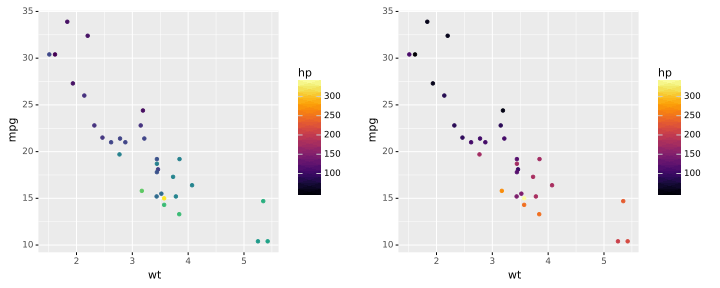

In [9]:
# example of the problem: notice that the 2 legends are the same. 
# You can manipulate the svg using the html editor to see how you can correct the second legend
_show_image(image_out,4,10)

In [10]:
# this global parameter holds svgs you can manipulate 
# (note that you should deepcopy these objects since svgs alter themselves)
store_images

{0: <svgutils.transform.SVGFigure at 0x7f822f3ba940>,
 1: <svgutils.transform.SVGFigure at 0x7f822f3bb3d0>}

In [11]:
# example how to get the string from the svg
my_svg = copy.deepcopy(store_images[1])
full_string = str(my_svg.to_str())

In [12]:
# need to identify start and end of svg to re-convert it to and svg_object
start = re.search("<svg", full_string)
end = re.search("</svg>", full_string)
end_svg = sg.fromstring(full_string[start.start():end.end()])


/Users/benjaminleroy/Documents/CMU/research/cowpatch/src/cowpatch/svg_utils.py:438: CowpatchWarning: Showing 4 x 5 inch image.


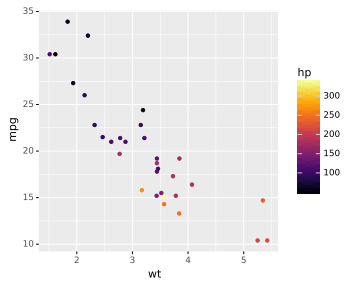

In [13]:
# Note that this image is also using above pair of svg information 
# (if you comment out the above ones, this will show correctly)
_show_image(end_svg, 4,5)

In [14]:
# How to visualize a set of potentially updated svg objects

In [15]:
base_created_image = sg.SVGFigure()
base_created_image.set_size((str(width_pt)+"pt", str(height_pt)+"pt"))
base_created_image.root.set("viewBox", "0 0 %s %s" % (str(width_pt), str(height_pt)))

# TODO: way to make decisions about the base image...
base_created_image.append(
    sg.fromstring("<rect width=\"100%\" height=\"100%\" fill=\"#FFFFFF\"/>"))

for p_idx in [0,1]:
    inner_svg = copy.deepcopy(store_images[p_idx])
    inner_root = inner_svg.getroot()
    inner_area = copy.deepcopy(store_location[p_idx])

    inner_root.moveto(x=inner_area.x_left,
                      y=inner_area.y_top)
    base_created_image.append(inner_root)

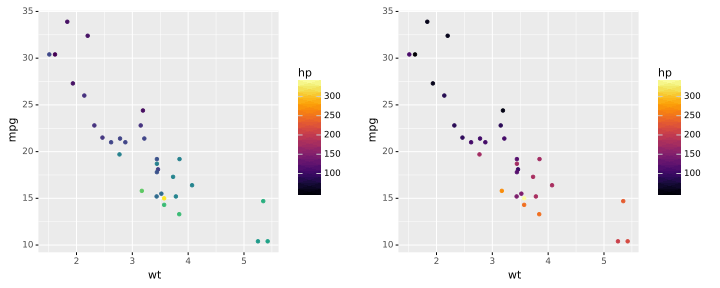

In [16]:
_show_image(base_created_image,4,10)